In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.nn import MessagePassing

# load pickle module
import pickle
import matplotlib.colors as colors
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import matplotlib.pyplot as plt
import scipy.special as SS
import scipy.stats as SSA

In [3]:
# create a graph
A = np.array([[0.25 , 0.25, 0.4, 0.1 ],
        [0.25, 0.75 , 0. , 0. ],
        [0.4, 0. , 0.55 , 0.05],
        [0.1 , 0 , 0.05, 0.85 ]])
# adjacency_matrix = torch.tensor(WN)
adjacency_matrix = torch.tensor(A)
# Get the indices where the adjacency matrix has a non-zero value
edge_index = torch.nonzero(adjacency_matrix, as_tuple=False).t()

# If your adjacency matrix has edge weights, you can get them like this:
edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]
xx = np.zeros((4,62))
xx[:, 1] = np.array([1000]*4)
xx[2,2] = 100
xx = torch.tensor(xx,dtype=torch.float)
data = Data(x=xx, edge_index=edge_index, edge_attr=edge_weight)

In [32]:
# %run ../codes/branchingv2.py

def get_new_infections_position(infectors, total_new, num_fips):
    cum_inft = np.cumsum(infectors)
    cum_new_infections = np.cumsum(total_new)

    totoal_new_infection_l = np.zeros(int(np.sum(total_new)))
    num_inft_s_idx = 0
    inft_s_idx = 0
    for l_indx in range(num_fips):
        num_inft = infectors[l_indx]
        if num_inft > 0:
            num_inft_e_idx = num_inft_s_idx+num_inft
            infection_list_l = total_new[num_inft_s_idx:num_inft_e_idx]
            # the list of the number of infections caused by every infector
            num_ift_l = np.sum(infection_list_l)
            inft_e_idx = inft_s_idx + num_ift_l
            totoal_new_infection_l[int(inft_s_idx):int(inft_e_idx)] = l_indx
            # the position of infection in the list of all infections
            num_inft_s_idx = num_inft_e_idx
            inft_s_idx = inft_e_idx
    return totoal_new_infection_l


def superspreading_T_Loc(T, num_fips, initials, nbi_para, pop, paras, WN, rand_seed):
    # initialise
    Z, Zb, D, Db = paras
    l0, i0 = initials
    r, p = nbi_para
    child_seeds = rand_seed.spawn(T)

    NewInf = np.zeros((num_fips, T))
    TotInf = np.zeros((num_fips, T))
    NewInf[l0, 0] = i0
    TotInf[:, 0] = NewInf[:, 0]

    for ti in range(T):
        infectors = np.int64(NewInf[:, ti])
        total_num_infectors = np.sum(infectors)
        pop_immu = 1-TotInf[:, ti]/pop[:]
        pop_immu[pop_immu < 0] = 0
        # create list of immu_prob * number of infectors
        immu_all = np.repeat(pop_immu, infectors)
        rng = np.random.default_rng(child_seeds[ti])
#         tt = rng.negative_binomial(r, p, total_num_infectors) ##################3
        tt = np.array([2]*total_num_infectors) 
        # xx = np.arange(0, 100, 1)  # define the range of x values the
        # calculate the probability mass function
        # pmf = SSA.nbinom.pmf(xx, r, p)
        # weights_n = pmf/np.sum(pmf)
        # tt = rng.choice(
        #     len(weights_n), size=total_num_infectors, p=weights_n)
        # to be assigned, every new infections for the infector
        total_new = np.round(tt*immu_all)
        totoal_new_infection_loc = get_new_infections_position(
            infectors, total_new, num_fips)

        z_num = np.int64(np.sum(total_new))
        NF = np.zeros((2, z_num), dtype=np.int64)
        # for the time distribution
        latency_p = SSA.gamma.rvs(a=Z, scale=Zb, size=z_num, random_state=rng)
        infectious_p = SSA.gamma.rvs(
            a=D, scale=Db, size=z_num, random_state=rng)
        v = rng.random(z_num)
#         delay_days = latency_p+v*infectious_p  # 3+5*0.5 ##################
        delay_days = np.array([2]*z_num)

        NF[0, :] = np.ceil(delay_days+ti)  # make it idx int
        # for the location distribution
        NF[1, :] = totoal_new_infection_loc
        df = pd.DataFrame(NF.T, columns=['time', 'o_l'])
        l_list = np.arange(num_fips)
        df['d_l'] = df['o_l'].apply(
            lambda x: np.random.choice(l_list, size=1, p=WN[:, x])[0])
        df = df[df['time'] <= (T-1)]
        NF_ii = np.array(df)
        for (t, o, d) in NF_ii:
            NewInf[d, t] = NewInf[d, t]+1
        TotInf = np.cumsum(NewInf, axis=1)

    return NewInf, TotInf

In [41]:
Z = 3  # latent period
Zb = 1  # scale parameter for Z
D = 5  # infectious period
Db = 1  # scale parameter for b
alpha = 0.1  # reporting rate 10%

# initialize variables
# seeding
l0 = 1859-1  # start with New York County NY in python -1, in matlab is 1859
# l0 = 2
i0 = 10
# T = 10
T = 60
r = 13.333
R0 = 1.5
p = r/(R0+r)
ss = np.random.SeedSequence(0)
# num_fips = 4
num_fips = len(pop)

E_NewInf = np.zeros((num_fips, T))
E_TotInf = np.zeros((num_fips, T))

# E_NewInf_i, E_TotInf_i = superspreading_T_Loc(
#     T, num_fips, (l0, i0), (r, p), np.array([1000]*4), (Z, Zb, D, Db), A, ss)
E_NewInf_i, E_TotInf_i = superspreading_T_Loc(
    T, num_fips, (l0, i0), (r, p), pop, (Z, Zb, D, Db), WN, ss)
E_NewInf[:, :] = E_NewInf_i[:, :T]
E_TotInf[:, :] = E_TotInf_i[:, :T]

KeyboardInterrupt: 

In [39]:
E_NewInf_i

array([[ 0.,  0., 10.,  0.,  8.,  0., 25.,  0., 45.,  0.],
       [ 0.,  0.,  0.,  0.,  7.,  0., 14.,  0., 36.,  0.],
       [10.,  0., 10.,  0., 19.,  0., 28.,  0., 53.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0., 13.,  0., 26.,  0.]])

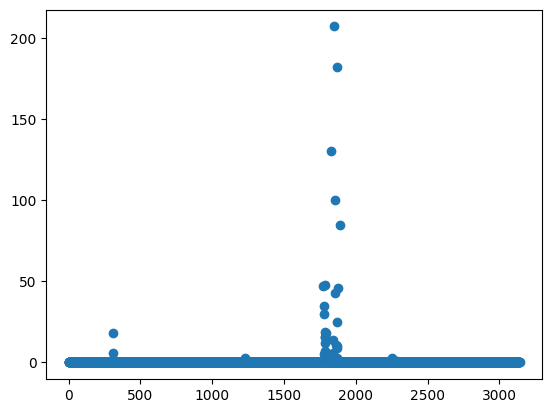

In [18]:
plt.scatter(range(3142), E_NewInf[:,-1], label='python') 

In [74]:
edge_index.shape

torch.Size([2, 17614])

In [75]:
3124*3141/2

4906242.0

In [43]:
import scipy.io

In [44]:
mat_data = scipy.io.loadmat('NewInf_13333.mat') #(3142, 60, 300)

In [45]:
mat_simulation = mat_data['NewInf']

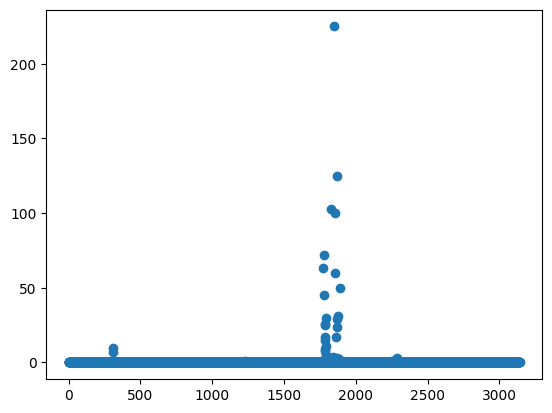

In [49]:
plt.scatter(range(3142),mat_simulation[:,-1,140])

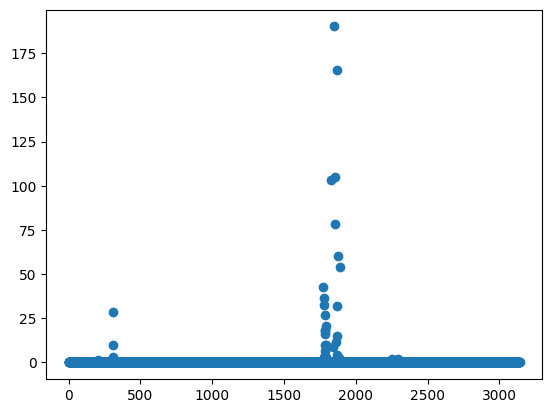

In [116]:
plt.scatter(range(3142),np.mean(mat_simulation[:,-1,:],axis=1))

In [200]:
R0 = 5.5
r = 0.025
p = r/(R0+r)
tt = np.random.negative_binomial(r, p, 10000)

(array([9.793e+03, 9.700e+01, 5.200e+01, 2.700e+01, 1.200e+01, 6.000e+00,
        3.000e+00, 3.000e+00, 6.000e+00, 1.000e+00]),
 array([  0.,  72., 144., 216., 288., 360., 432., 504., 576., 648., 720.]),
 <BarContainer object of 10 artists>)

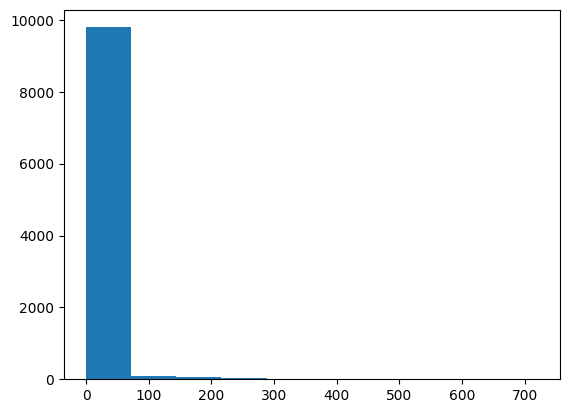

In [201]:
plt.hist(tt)